In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.stats as stats

---

<h1><center>
    <br><br> Gradient Descent and <br> Stochastic Gradient Descent </center></h1>

---

# Introduction

In this lab we will explore the gradient descent and stochastic gradient descent algorithms for solving a least squares optimization problem. The setup is as follows. We wish to model a process with scalar input $X$ and scalar output $Y$. Both of these are real-valued random variables; their sample spaces are the real line. The joint distribution of $X$ and $Y$ is given as:
\begin{align*}
X &\sim \mathcal{U}(0,1) \\
Y|X\!=\!x &\sim \mathcal{N}( \theta_0 + \theta_1 x ,\sigma_\epsilon)
\end{align*}
This definition of $Y|X\!=\!x$ is equivalent to,
\begin{equation*}
Y = \theta_0 + \theta_1 X + \epsilon
\end{equation*}
with $\epsilon\sim\mathcal{N}(0,\sigma_\epsilon^2)$.

# 1. Sampling the joint distribution

We will first construct a synthetic dataset by sampling  from $(X,Y)$. 

Write a function called `sampleXY` that produces a dataset $\{(x_i,y_i)\}_N$ of iid samples from $(X,Y)$, given arguments $N$, $\theta_0$, $\theta_1$, and $\sigma_\epsilon$. The output of this function should be a numpy array with shape = $(N,2)$. 

In [7]:
def sampleXY(N, theta0, theta1, sigma_eps):
    X = np.random.uniform(low=0.0, high=1.0, size=N)
    eps = np.random.normal(loc=0, scale=sigma_eps, size=N)
    Y = theta0 + theta1*X + eps
    
    
    data = []
    for i in range(N):
        Px = X[i]
        Py = Y[i]
        data_array = data.append([Px, Py])
        
    return np.array(data)
    

print(sampleXY(10, 1, 1, 1))
print(np.shape(sampleXY(10, 1, 1, 1)))

[[0.83840872 3.240696  ]
 [0.06495039 0.83141713]
 [0.90778558 2.8511544 ]
 [0.69823012 1.88585595]
 [0.00417162 2.01374428]
 [0.16332904 2.47566436]
 [0.85008786 0.80931867]
 [0.1232672  1.74088544]
 [0.52359906 2.50752937]
 [0.70939907 2.07893066]]
(10, 2)


Run `sampleXY` with $N\!=\!40$, $\theta_0\!=\!0.2$, $\theta_1\!=\!-0.4$, and $\sigma_\epsilon\!=\!0.07$ and assign the result to the variable `XYsamp`. Create a plot showing the line $y=\theta_0 + \theta_1 x$, overlaid with a scatter plot of `XYsamp`. The plot should have labels on the x and y axes.

In [8]:
N = 40
theta0=0.2
theta1=-0.4
sigma_eps= 0.07
XYsamp = sampleXY(N, theta0, theta1, sigma_eps)

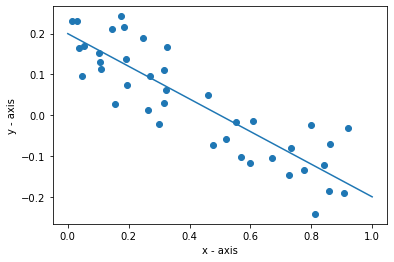

In [9]:
x = np.linspace(0,1,100)
y = theta0 + theta1*x

fig1 = plt.figure()

plt.plot(x, y)

plt.scatter(XYsamp[:,0],XYsamp[:,1])

plt.xlabel('x - axis')
plt.ylabel('y - axis')

plt.show()

We will now overwrite the data you sampled with another dataset contained in the file `1d_data.pickle`. This is so the results are predictable.

In [10]:
with open('./1d_data.pickle', 'rb') as file:
    XYsamp = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: './1d_data.pickle'

In [13]:
print(XYsamp)
print(len(XYsamp))
print(np.shape(XYsamp))

[[ 0.26080771 -0.0167954 ]
 [ 0.33699405  0.09963627]
 [ 0.36929101  0.10978001]
 [ 0.41854395  0.02639039]
 [ 0.07099163  0.2208093 ]
 [ 0.25136018  0.02889733]
 [ 0.83548999 -0.24428549]
 [ 0.55188738  0.08502048]
 [ 0.75609632 -0.03562489]
 [ 0.59377784 -0.04921159]
 [ 0.65722805 -0.03271674]
 [ 0.1941553   0.07420796]
 [ 0.05033221  0.10294424]
 [ 0.49500122  0.0403545 ]
 [ 0.43163632 -0.02684472]
 [ 0.84496277 -0.14854758]
 [ 0.15355817  0.21085325]
 [ 0.28428282  0.07357161]
 [ 0.13475872  0.07480284]
 [ 0.96860861 -0.23916899]
 [ 0.02012632  0.27773011]
 [ 0.98826914 -0.33991   ]
 [ 0.61076725 -0.00661786]
 [ 0.49688813 -0.02245188]
 [ 0.80240783 -0.04968038]
 [ 0.40749308  0.02342941]
 [ 0.67387563  0.02968287]
 [ 0.84315809 -0.20912494]
 [ 0.35849541  0.08197205]
 [ 0.99158839 -0.22273146]
 [ 0.11928999  0.18340278]
 [ 0.95610376 -0.2000605 ]
 [ 0.69261867 -0.03670628]
 [ 0.06892167  0.13125948]
 [ 0.27831576  0.05428888]
 [ 0.12936627  0.23922464]
 [ 0.68575167 -0.0990357 ]
 

# 2. Gradient descent for linear regression

We are still a few weeks from learning about linear regression. However here we will use the optimization problem at the center of linear regression to demonstrate gradient descent and stochastic gradient descent. 

Our dataset `XYsamp` contains $N$ tuples $(x_i,y_i)$. Our goal now is to find parameters $\hat\theta_0$ and $\hat\theta_1$ that minimize a quadratic cost function. 

\begin{equation*}
J(\hat\theta_0,\hat\theta_1) = \frac{1}{N} \sum_{i=1}^{N} \left( \hat\theta_0 + \hat \theta_1 x_i - y_i \right)^2
\end{equation*}

The update equation for gradient descent is:

\begin{equation*}
\theta_{k+1} = \theta_k -\gamma \nabla J(\theta_k)
\end{equation*}

$\theta_{k}$ is a vector of the estimates $\hat\theta_0$ and $\hat\theta_1$ after $k$ steps of gradient descent. The gradient of $J$ is:

\begin{align*}
\nabla J(\hat\theta_0,\hat\theta_1) &= 
\frac{1}{N} \sum_{i=1}^{N} \nabla\left( \hat\theta_0 + \hat \theta_1 x_i - y_i \right)^2  \\
&= 
\frac{1}{N} \sum_{i=1}^{N} 2\left( \hat\theta_0 + \hat \theta_1 x_i - y_i \right)\begin{bmatrix} 1 \\ x_i \end{bmatrix}
\end{align*}



## (2a)

Write a function called `nablaJ` that takes `XYsamp`, $\hat\theta_0$, and $\hat\theta_1$ as inputs, and returns the gradient as a numpy array of length 2.

In [15]:
def nablaJ(XYsamp, thetahat0, thetahat1):
    
    N = XYsamp.shape[0]
    
    dthetahat0 = []
    dthetahat1 = []
    nablaJ = []
    
    for i in range(N):
        dthetahat0.append(thetahat0 + thetahat1*XYsamp[i,0]-XYsamp[i,1])
    for i in range(N):
        dthetahat1.append(XYsamp[i,0]*(thetahat0 + thetahat1*XYsamp[i,0]-XYsamp[i,1]))
    
    sum_dthetahat0 = (2/N) * sum(dthetahat0)
    sum_dthetahat1 = (2/N) * sum(dthetahat1)
    nablaJ.append(sum_dthetahat0)
    nablaJ.append(sum_dthetahat1)
    
    return nablaJ
    
print(nablaJ(XYsamp, 1, 2))
print(np.shape(nablaJ(XYsamp, 1, 2)))

[3.9786717107168643, 2.3883273643656455]
(2,)


In [16]:
################################
# Reporting. Do not modify.#####
result['nablaJ_2a_a'] = nablaJ(XYsamp,0.5,-1)    
result['nablaJ_2a_b'] = nablaJ(XYsamp,1.1,0.6)    
################################

## (2b)

Write a function called `gradient_descent` that executes the gradient descent algorithm. This function should take as input 

+ The dataset `XYsamp`
+ the total number of steps to take `K`
+ the step size `gamma`
+ the initial condition `theta_init` as a numpy array of length 2. 

It should return the trajectory as a 2D numpy array with shape = `(K,2)`. 

In [19]:
def gradient_descent(XYsamp,K,gamma,theta_init):

    d = XYsamp.shape[1]
    Theta = np.empty((K, d))
    
    for i in range(K):
        nablaJ_thetaK = np.array(nablaJ(XYsamp, theta_init[0],theta_init[1])) #nablaJ with thetaK as input
        theta_init = theta_init - gamma*nablaJ_thetaK
        Theta[i] = [theta_init[0],theta_init[1]]
       
    return Theta
    

gradient_descent(XYsamp,10,0.02,[0.5,-0.5])

array([[ 0.48997488, -0.50470401],
       [ 0.48044399, -0.50914695],
       [ 0.47138239, -0.51334207],
       [ 0.46276641, -0.51730197],
       [ 0.45457354, -0.52103859],
       [ 0.44678245, -0.52456329],
       [ 0.43937285, -0.52788682],
       [ 0.43232552, -0.53101943],
       [ 0.42562216, -0.53397083],
       [ 0.41924543, -0.53675023]])

In [20]:
################################
# Reporting. Do not modify.#####
result['gd_2b_a'] = gradient_descent(XYsamp,10,0.1,np.array([-0.5,0.5]))  
result['gd_2b_b'] = gradient_descent(XYsamp,20,0.01,np.array([0.5,-0.5]))  
################################

## (2c)

Complete the `run_gd_on_grid(theta0_grid,theta1_grid,K,gamma)`. This function takes as input
+ `theta0_grid` and `theta1_grid`. These are two 5x5 grids of values of $\hat\theta_0$ and $\hat\theta_1$. 
+ the total number of steps to take `K`
+ the step size `gamma`

The function should return a numpy array with shape (5,5,K,2), where the (i,j,:,:) is a (K,2) trajectory of parameter values, and (i,j) are the indices to the 5x5 arrays.

Run the function with $K=200$, $\gamma=0.2$ and save the result to `trajectories`.

Note: The code for creating the 5x5 grid is provided. 

In [21]:
# Do not alter this code. It creates the 5x5 grid of values 
# that are passed to `run_gd_on_grid`
def make_grid(gridN):
    theta_0_array = np.linspace(-1,1,gridN)
    theta_1_array = np.linspace(-1,1,gridN)
    return  np.meshgrid(theta_0_array,theta_1_array)

gridN = 5
theta0_grid,theta1_grid = make_grid(gridN)

In [22]:
print(theta0_grid)
print(theta1_grid)
print(theta0_grid[0][3])

[[-1.  -0.5  0.   0.5  1. ]
 [-1.  -0.5  0.   0.5  1. ]
 [-1.  -0.5  0.   0.5  1. ]
 [-1.  -0.5  0.   0.5  1. ]
 [-1.  -0.5  0.   0.5  1. ]]
[[-1.  -1.  -1.  -1.  -1. ]
 [-0.5 -0.5 -0.5 -0.5 -0.5]
 [ 0.   0.   0.   0.   0. ]
 [ 0.5  0.5  0.5  0.5  0.5]
 [ 1.   1.   1.   1.   1. ]]
0.5


In [23]:
def run_gd_on_grid(theta0_grid,theta1_grid,XYsamp,K,gamma):
    gridN = theta0_grid.shape[0]
    traj = np.empty((gridN,gridN,K,2))
    
    # ADD CODE HERE
    for i in range(gridN):
        for j in range(gridN):

            x = gradient_descent(XYsamp,K,gamma,[theta0_grid[i][j],theta1_grid[i][j]])
            traj[j] = x           
        
    return traj

run_gd_on_grid(theta0_grid,theta1_grid,XYsamp,K=200,gamma=0.2)
print(gridN)

5


In [24]:
trajectories = run_gd_on_grid(theta0_grid,theta1_grid,XYsamp,K=200,gamma=0.2)

print((trajectories.shape))

(5, 5, 200, 2)


In [25]:
################################
# Reporting. Do not modify.#####
result['grid_2c'] = run_gd_on_grid(theta0_grid,theta1_grid,XYsamp,K=200,gamma=0.2) 
################################

## (2d)

In this synthetic example, we actually know the true values of $\theta_0$ and $\theta_1$, since these were used to generate the data (they are stored as `theta0` and `theta1`. So we can explicitly compute the 2-norm of the estimation error for candidates $\hat\theta_0$ and $\hat\theta_1$ with:

\begin{equation*}
e = \sqrt{ (\hat\theta_0-\theta_0)^2 + (\hat\theta_1-\theta_1)^2 } 
\end{equation*}

Write a function called `compute_error` that makes this calculation. The function should take inputs `theta0hat`, `theta1hat`, `theta0`, `theta1`, and should return a scalar value for the error.

In [26]:
def compute_error(theta0hat, theta1hat, theta0, theta1):
    x = np.array(theta0hat) - np.array(theta0)
    y = np.array(theta1hat) - np.array(theta1)
    w = np.dot(x,x) + np.dot(y,y)
    z = np. sqrt(w)
    
    return z
    
compute_error([1,2], [2,3], [2,3], [1,2])

2.0

The following method will use your `compute_error` method to plot the evolution of the error in gradient descent. It plots the error trajectory for all 25 initial conditions on a 5x5 grid. 

In [27]:
def plot_error(trajectories):
    
    gridN = trajectories.shape[0]
    K = trajectories.shape[2]
    d = trajectories.shape[3]

    fig = plt.figure(figsize=(12,5))
    for i0 in range(gridN):
        for i1 in range(gridN):
            traj = trajectories[i0,i1,:,:]
            error = np.empty(K)
            for k in range(K):
                error[k] = compute_error(traj[k,0], traj[k,1], theta0, theta1)
            plt.semilogy(range(K),error)

    plt.xlabel('k',fontsize=15)
    plt.ylabel('error',fontsize=15)
    plt.grid()
    
    return fig

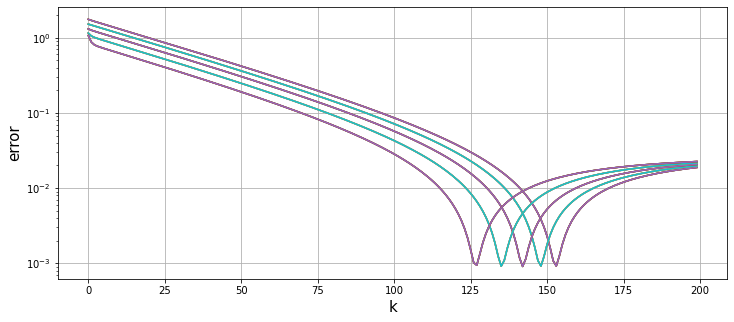

In [28]:
################################
# Reporting. Do not modify.#####
result['fig_2d'] = plot_error(result['grid_2c'])
################################

## (2e)

The `plot_quiver` function provided below creates a vector field plot of the negative gadient $-\nabla J(\theta_0,\theta_1)$. It also marks the true value of the parameters with a blue dot. 

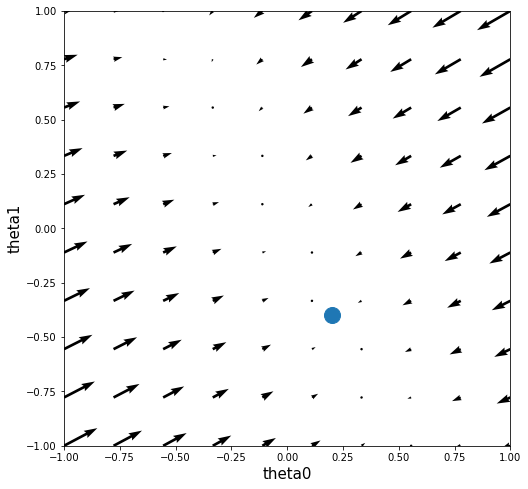

In [29]:
def plot_quiver(XYsamp):    
    gridN = 10
    theta0_grid, theta1_grid = make_grid(gridN)
    flatgrid = np.reshape([theta0_grid, theta1_grid],(2,gridN**2)).T
    UV = np.empty(flatgrid.shape)
    for i, (theta0z, theta1z) in enumerate(flatgrid):
        UV[i,:] = nablaJ(XYsamp,theta0z, theta1z)
    
    fig = plt.figure(figsize=(8,8))
    plt.quiver(flatgrid[:,0], flatgrid[:,1],-UV[:,0],-UV[:,1],scale=N)
    
    plt.xlabel('theta0',fontsize=15)
    plt.ylabel('theta1',fontsize=15)
    plt.plot(theta0,theta1,'o',markersize=16)
    plt.axis([-1,1,-1,1])
    return fig

plot_quiver(XYsamp);


Your task is to complete the `plot_traj` function. The inputs to this function are:
+ `fig`: the output of `plot_quiver` (a figure handle)
+ `trajectories`: a set of gradient descent trajectories generate by `run_gd_on_grid`.

The function should overlay these trajectories on top of the vector field. The style of the trajectory lines should be `'.-'` and it should have these characteristics:
+ `color='red'`
+ `linewidth=0.5`
+ `markersize=2`

In [30]:
def plot_traj(fig,trajectories):  
    
    for i in range(gridN):
        for j in range(gridN):

            x = trajectories[j,0]           
            y = trajectories[j,1]
            plt.plot(x,y, 'r.-', color="red", linewidth = 0.5, markersize = 2)
                

    return fig

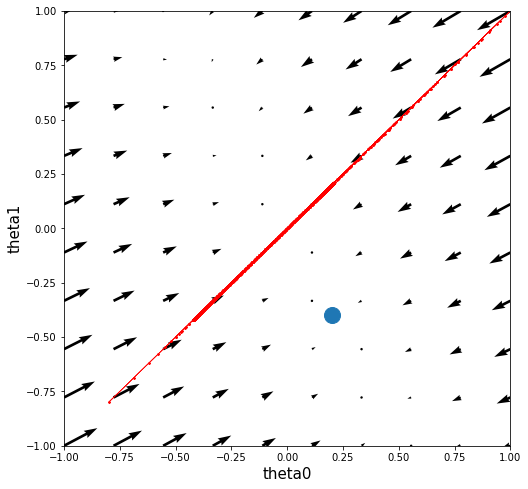

In [31]:
plot_traj(plot_quiver(XYsamp),trajectories);

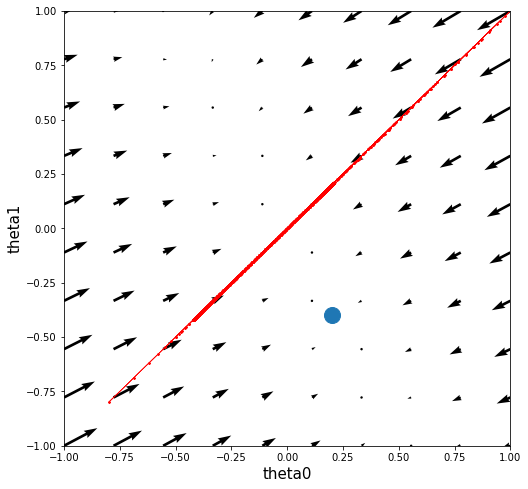

In [32]:
################################
# Reporting. Do not modify.#####
result['fig_2e'] = plot_traj(plot_quiver(XYsamp),result['grid_2c'])  
################################

## (2f)

The next two cells generate the convergence and phase plots with $\gamma=0.01$ and $\gamma=0.7$.

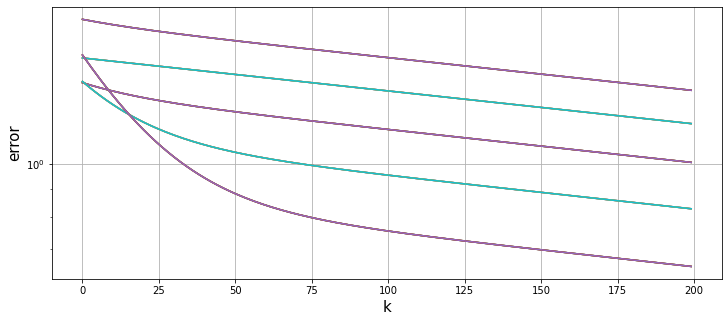

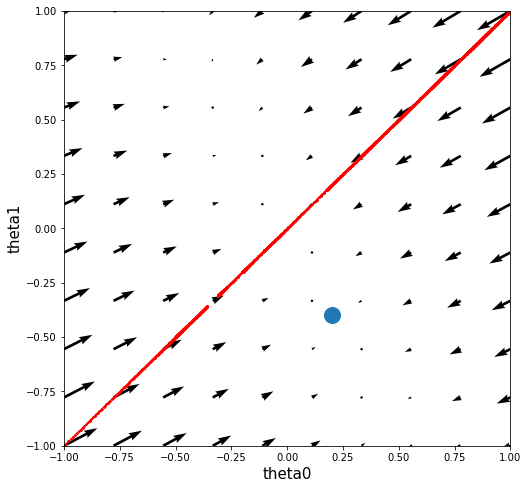

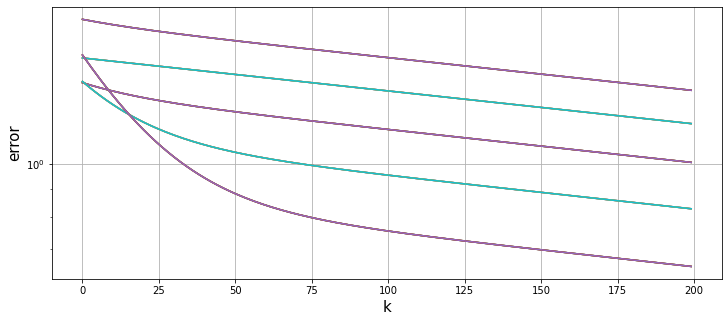

In [33]:
trajectories2 = run_gd_on_grid(theta0_grid,theta1_grid,XYsamp,K=200,gamma=0.01)
plot_traj(plot_quiver(XYsamp),trajectories2)
plot_error(trajectories2)

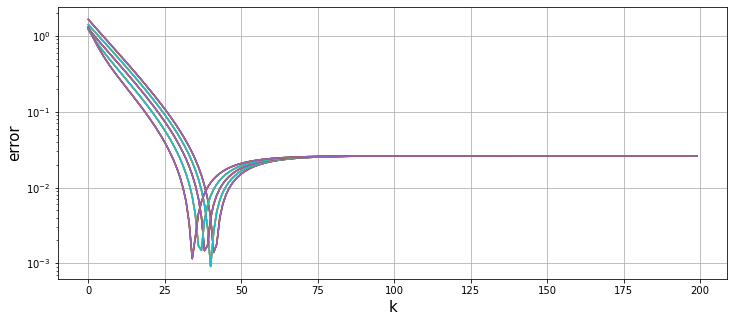

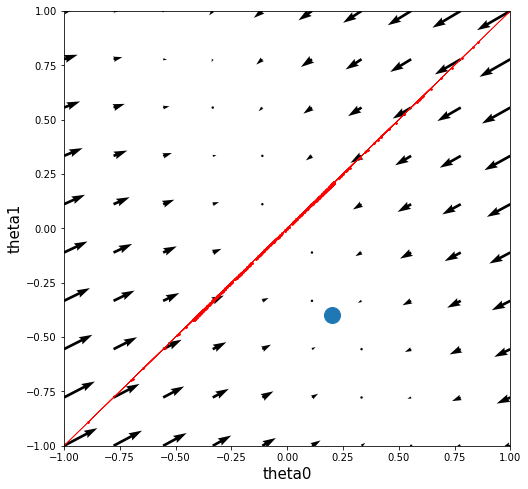

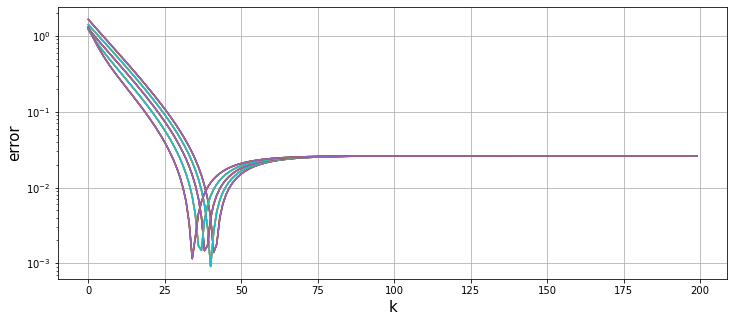

In [34]:
trajectories3 = run_gd_on_grid(theta0_grid,theta1_grid,XYsamp,K=200,gamma=0.7)
plot_traj(plot_quiver(XYsamp),trajectories3)
plot_error(trajectories3)

What do you observe about the influence of the step size on the convergence of gradient descent?

In [35]:
comment = 'between K = 25 to 50 steps, is where the gradient descent function is the most accurate as it has the least error value'

In [36]:
################################
# Reporting. Do not modify.#####
result['comment2f'] = comment   # 4 points
################################

# 3. Additive cost

There is no deliverable for this part. The goal is to introduce a plot that will be used in the next part. Run the next cell to generate the plot.

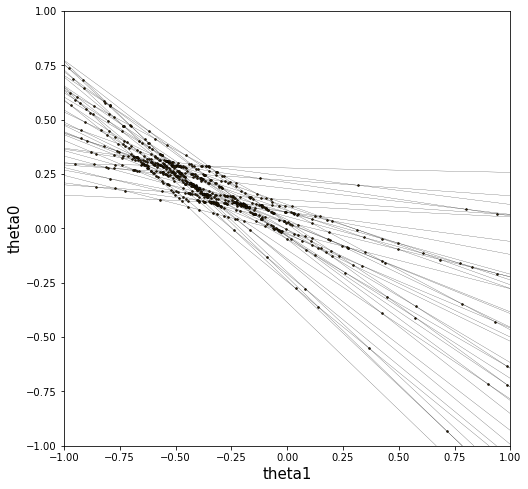

In [42]:
def find_intersections(XYsamp):
    x = XYsamp[:,0]
    y = XYsamp[:,1]
    N = XYsamp.shape[0]
    points = []
    for a in range(N - 1):
        for b in np.arange(a + 1, N):
            p0 = (y[a] * x[b] - y[b] * x[a]) / (x[b] - x[a])
            p1 = (y[b] - y[a]) / (x[b] - x[a])
            points.append([p0, p1])
    return np.array(points)

def plot_additive_grads(XYsamp):

    x = XYsamp[:,0]
    y = XYsamp[:,1]
    
    points = find_intersections(XYsamp)
    fig = plt.figure(figsize=(8,8))
    for n in range(N):
        plt.plot([-1,(1+y[n])/x[n]],[y[n]+x[n],-1],'k',linewidth=0.2)
    plt.plot(points[:,1],points[:,0],'k.',markersize=3 ,markerfacecolor='orange')
    plt.xlabel('theta1',fontsize=15)
    plt.ylabel('theta0',fontsize=15)
    plt.axis([-1,1,-1,1])
    return fig

plot_additive_grads(XYsamp);

In the context of stochastic gradient descent, the cost function that we are trying to minimize is the average over $N$ small cost functions:

\begin{equation*}
\ell_i(\hat\theta_0,\hat\theta_1) = \left( \hat\theta_0 + \hat \theta_1 x_i - y_i \right)^2
\end{equation*}

each one associated with the data point $(x_i,y_i)$.

\begin{align*}
J(\hat\theta_0,\hat\theta_1) &= \frac{1}{N} \sum_{i=1}^{N} \left( \hat\theta_0 + \hat \theta_1 x_i - y_i \right)^2 \\
&= \frac{1}{N} \sum_{i=1}^{N} \ell_i(\hat\theta_0,\hat\theta_1)
\end{align*}

The gradient of $J$ is then the average if the gradients of the $\ell_i$'s:

\begin{align*}
\nabla J(\hat\theta_0,\hat\theta_1) &= \frac{1}{N} \sum_{i=1}^{N} \nabla\ell_i(\hat\theta_0,\hat\theta_1)
\end{align*}

Let's take a particular $\ell_i$ and find its minimum. Since $\ell_i$ is always positive, its minimum is wherever it equals zero. This is along a line in the $(\hat\theta_0,\hat\theta_1)$ plane:

\begin{equation*}
\hat\theta_0 + \hat\theta_1 x_i - y_i = 0
\end{equation*}

The plot above shows each of those $N$ lines. The black dots are the intersections of two lines. These would be exact solutions if only a pair of data points were given ($N=2$). 

# 4. Stochastic Gradient Descent

## 4(a)

Code stochastic gradient descent. Complete the function `SGD` below. This function takes as arguments 
+ the dataset `XYsamp`, 
+ the step size $\gamma$ and 
+ the number of epochs to run. 

`SGD` function should

+ randomly choose the initial condition with uniform probability from $[-1,1]\times[-1,1]$
+ use batches of size 1,
+ draw samples without replacement.

The function should return the parameter trajectory. 


Run SGD with $\gamma=0.1$ and 10 epochs. Recreate the plot from part 2 but using this SGD trajectory instead of GD. Save the figure handle as `fig4a`.

In [43]:
def SGD(XYsamp,gamma,epochs):
    
    x = XYsamp[:,0]
    y = XYsamp[:,1]
    N = XYsamp.shape[0]
    traj = np.empty((epochs*N+1,2))   
   
    
    for i in range(epochs*N+1):
        thetahat0_rand = np.random.uniform(low=-1.0, high=1.0, size=1)
        thetahat1_rand = np.random.uniform(low=-1.0, high=1.0, size=1)
        nablaJ_theta = np.array(nablaJ(XYsamp, thetahat0_rand, thetahat1_rand)) #nablaJ with thetahat0_rand,thetahat1_rand as input
        equation = [thetahat0_rand,thetahat1_rand] - gamma*nablaJ_theta
        traj[i][0] = equation[0]
        traj[i][1] = equation[1]
               
    sol = traj[:-1,:]
            
    return sol

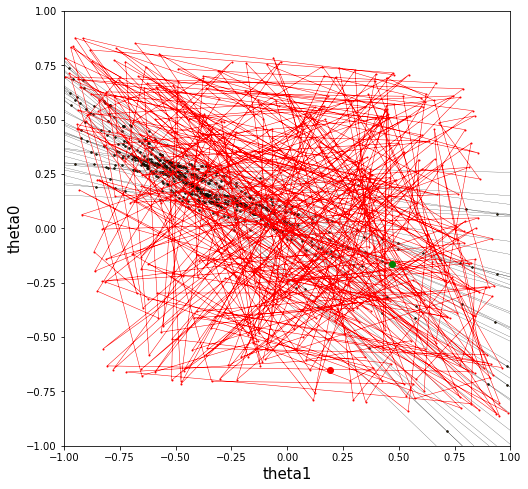

In [44]:
fig4a = plot_additive_grads(XYsamp)

traj = SGD(XYsamp,0.1,10)
plt.plot(traj[:,1],traj[:,0],'r.-',linewidth=0.5,markersize=2)
plt.plot(traj[0,1],traj[0,0],'og')
plt.plot(traj[-1,1],traj[-1,0],'or')

In [45]:
################################
# Reporting. Do not modify.#####
result['fig4a'] = fig4a 
################################

## 4(b)

Make the same plot with $\gamma=0.01$ and $\gamma=0.4$. Save the figure handles respectively as `fig4b1` and `fig4b2`.

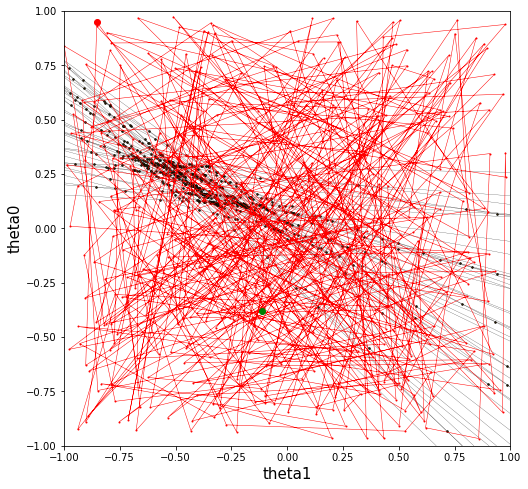

In [46]:
fig4b1 = plot_additive_grads(XYsamp)

traj = SGD(XYsamp,0.01,10)
plt.plot(traj[:,1],traj[:,0],'r.-',linewidth=0.5,markersize=2)
plt.plot(traj[0,1],traj[0,0],'og')
plt.plot(traj[-1,1],traj[-1,0],'or')

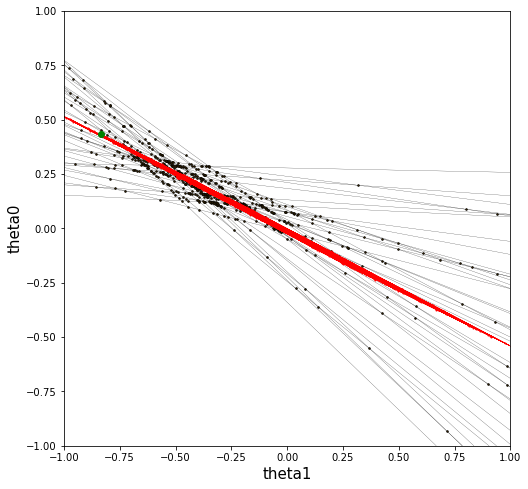

In [47]:
fig4b2 = plot_additive_grads(XYsamp)

traj = SGD(XYsamp,0.4,10)
plt.plot(traj[:,1],traj[:,0],'r.-',linewidth=0.5,markersize=2)
plt.plot(traj[0,1],traj[0,0],'og')
plt.plot(traj[-1,1],traj[-1,0],'or')

In [48]:
################################
# Reporting. Do not modify.#####
result['fig4b1'] = fig4b1   
result['fig4b2'] = fig4b2   
################################

## 4(c)

Comment on the pros and cons of SGD with respect to GD. Save your comments in a string called `comment`. 

In [49]:
comment = 'SGD is faster and more efficient than GD, however, it is much noisier than GD, as it is not calculating the actual gradient, but more of an approximation of the gradient.'

In [50]:
################################
# Reporting. Do not modify.#####
result['comment'] = comment   
################################

---
## Do not modify below this

In [51]:
with open('{}.pickle'.format("_".join([str(sid) for sid in result['SIDs']])),'wb') as file:
    pickle.dump(result,file)